In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Data generation

In [2]:
A_true = 1.
b_true = 50.

limit = 10
data_size = 1000

D = np.linspace(-limit, limit, num=data_size)
y = A_true * D + b_true + np.random.randn(data_size)

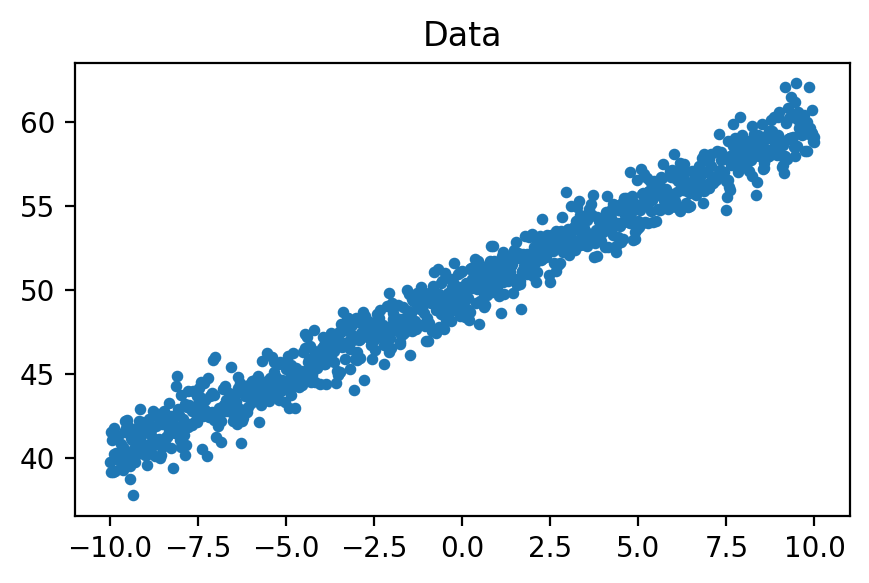

In [3]:
plt.figure(figsize=(5, 3), dpi=200)
plt.title('Data')
plt.scatter(D, y, s=10);

### Training

In [4]:
num_epoches = 5001
batch_size = 250
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torchType = torch.float32

In [5]:
b_mu = nn.Parameter(torch.tensor(0., dtype=torchType, device=device))
b_logvar = nn.Parameter(torch.tensor(0., dtype=torchType, device=device))

A = nn.Parameter(torch.tensor(0., dtype=torchType, device=device))

In [6]:
optimizer = torch.optim.Adam(params=[b_mu, b_logvar, A], lr=0.01)

In [7]:
data = torch.tensor(np.concatenate((D[:, None], y[:, None]), axis=-1), device=device, dtype=torchType)
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torchType),
                                       scale=torch.tensor(1., device=device, dtype=torchType),)
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size)

ELBO value is -411385.6875 on epoch number 0
Mean of b is 0.040115583688020706, std of b is 1.0006684064865112


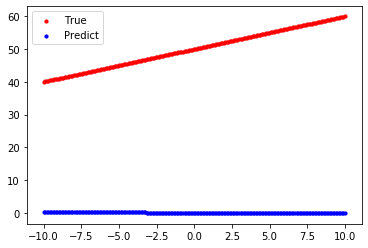

ELBO value is -34820.8046875 on epoch number 1000
Mean of b is 33.450927734375, std of b is 0.6979825496673584


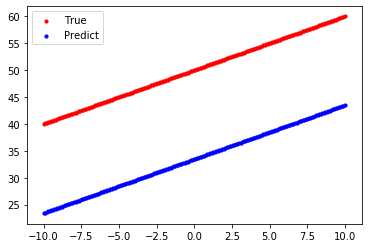

ELBO value is -1568.727294921875 on epoch number 2000
Mean of b is 49.4335823059082, std of b is 0.3609973192214966


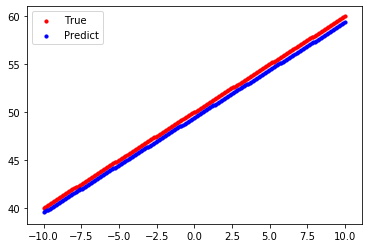

ELBO value is -1590.83935546875 on epoch number 3000
Mean of b is 49.7718620300293, std of b is 0.14450900256633759


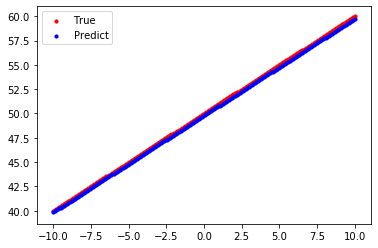

ELBO value is -1597.90625 on epoch number 4000
Mean of b is 49.77439498901367, std of b is 0.040740787982940674


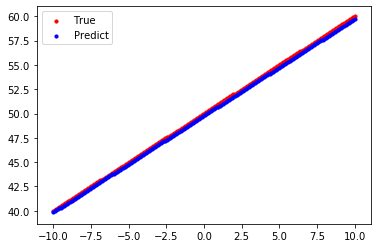

ELBO value is -1587.859619140625 on epoch number 5000
Mean of b is 49.78175735473633, std of b is 0.0009297585929743946


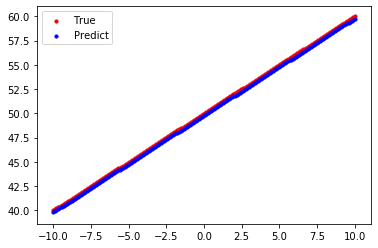

In [8]:
for ep in range(num_epoches):
    plt.close()
    for batch in dataloader:
        x_train, y_train = batch[:, 0], batch[:, 1]
        b = b_mu + std_normal.sample(b_mu.shape) * torch.exp(0.5 * b_logvar)
        
        y_pred = A * x_train + b
        
        log_likelihood = std_normal.log_prob(y_train-y_pred).sum()
        KL = (0.5 * (b_logvar + torch.exp(b_logvar) + b_mu ** 2 - 1.))
        
        elbo = log_likelihood - KL
        (-elbo).backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
    if ep % 1000 == 0:
        print(f'ELBO value is {elbo.cpu().detach().numpy()} on epoch number {ep}')
        print(f'Mean of b is {b_mu.detach()}, std of b is {torch.exp(0.5 * b_logvar.detach())}')
        
        x_val = np.linspace(-limit, limit, 200)
        
        y_val = A_true * x_val + b_true
        y_pred_val = A.cpu().detach().numpy() * x_val + b_mu.cpu().detach().numpy()
        
        plt.scatter(x_val, y_val, c='r', s=10, label='True')
        plt.scatter(x_val, y_pred_val, c='b', s=10, label='Predict')
        plt.legend()
        plt.show();